## Import data and libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization, Activation, Input, Bidirectional, LSTM
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

/var/folders/nx/nd5hy9z92p18k3jpbyyqw3m80000gn/T/ipykernel_89291/3804295307.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Plot accuracy and loss
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

In [4]:
df_master = pd.read_csv("../data/Train.csv")
df = df_master.copy()
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [5]:
df.shape

(2154048, 19)

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


In [7]:
round(df.isna().sum().sort_values(ascending=False) / len(df), 4) * 100

ZONE2             93.65
ZONE1             92.12
TIGO              59.89
DATA_VOLUME       49.23
FREQ_TOP_PACK     41.90
TOP_PACK          41.90
ORANGE            41.56
REGION            39.43
ON_NET            36.52
MONTANT           35.13
FREQUENCE_RECH    35.13
REVENUE           33.71
ARPU_SEGMENT      33.71
FREQUENCE         33.71
REGULARITY         0.00
user_id            0.00
MRG                0.00
TENURE             0.00
CHURN              0.00
dtype: float64

In [8]:
df.TOP_PACK.unique()

array(['On net 200F=Unlimited _call24H', nan, 'On-net 1000F=10MilF;10d',
       'Data:1000F=5GB,7d', 'Mixt 250F=Unlimited_call24H',
       'MIXT:500F= 2500F on net _2500F off net;2d',
       'All-net 500F=2000F;5d', 'On-net 500F_FNF;3d',
       'Data: 100 F=40MB,24H', 'MIXT: 200mnoff net _unl on net _5Go;30d',
       'Jokko_Daily', 'Data: 200 F=100MB,24H', 'Data:490F=1GB,7d',
       'Twter_U2opia_Daily', 'On-net 500=4000,10d', 'Data:1000F=2GB,30d',
       'IVR Echat_Daily_50F', 'Pilot_Youth4_490',
       'All-net 500F =2000F_AllNet_Unlimited', 'Twter_U2opia_Weekly',
       'Data:200F=Unlimited,24H', 'On-net 200F=60mn;1d',
       'All-net 600F= 3000F ;5d', 'Pilot_Youth1_290',
       'All-net 1000F=(3000F On+3000F Off);5d', 'VAS(IVR_Radio_Daily)',
       'Data:3000F=10GB,30d', 'All-net 1000=5000;5d',
       'Twter_U2opia_Monthly', 'MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t',
       'FNF2 ( JAPPANTE)', 'Yewouleen_PKG', 'Data:150F=SPPackage1,24H',
       'WIFI_Family_2MBPS', 'Data:500F=2GB,2

In [9]:
df.REGION.unique() 

array(['FATICK', nan, 'DAKAR', 'LOUGA', 'TAMBACOUNDA', 'KAOLACK', 'THIES',
       'SAINT-LOUIS', 'KOLDA', 'KAFFRINE', 'DIOURBEL', 'ZIGUINCHOR',
       'MATAM', 'SEDHIOU', 'KEDOUGOU'], dtype=object)

In [10]:
df.MRG.unique()

array(['NO'], dtype=object)

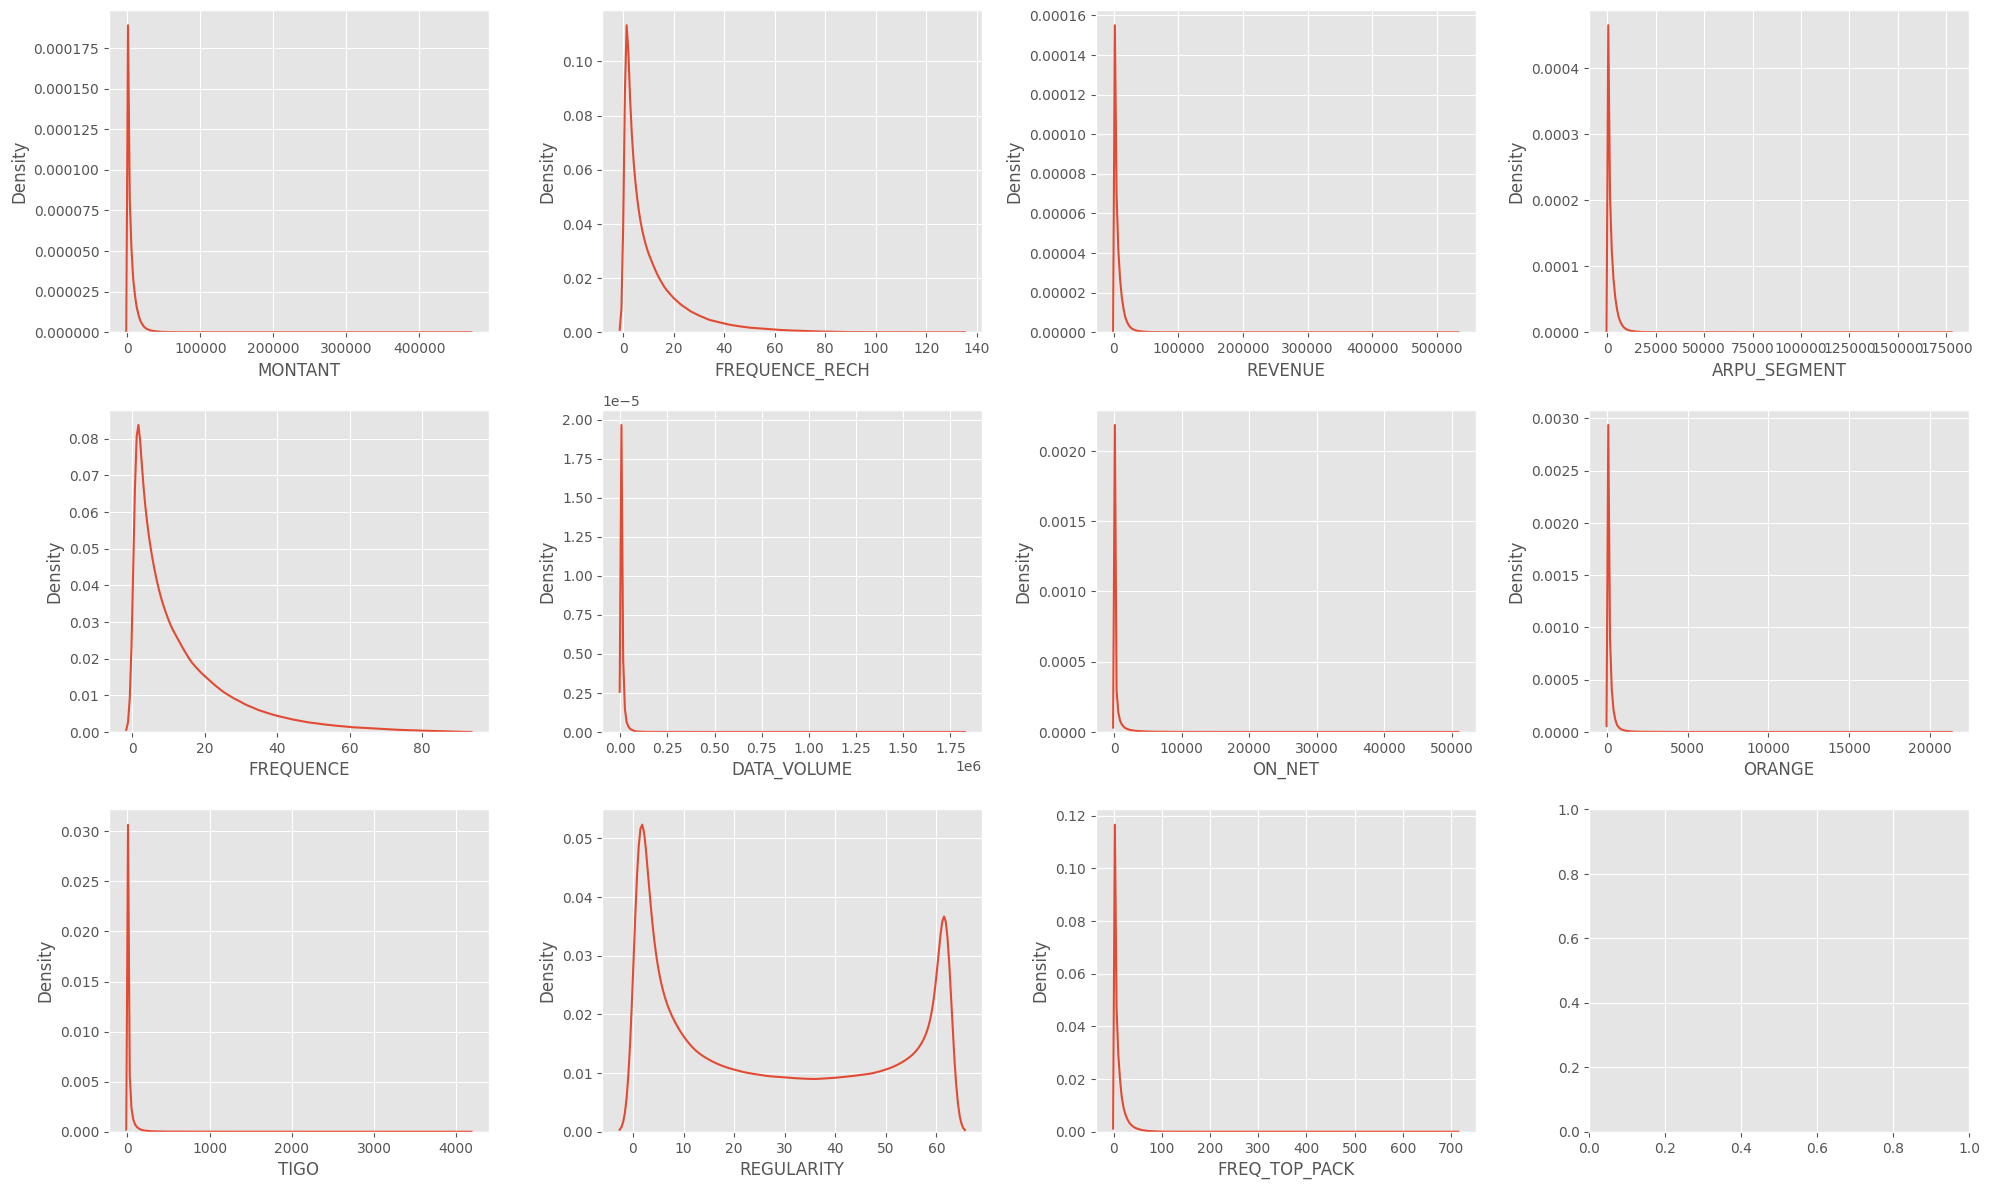

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

sns.kdeplot(data=df, x="MONTANT", ax=axes[0, 0])
sns.kdeplot(data=df, x="FREQUENCE_RECH", ax=axes[0, 1])
sns.kdeplot(data=df, x="REVENUE", ax=axes[0, 2])
sns.kdeplot(data=df, x="ARPU_SEGMENT", ax=axes[0, 3])

sns.kdeplot(data=df, x="FREQUENCE", ax=axes[1, 0])
sns.kdeplot(data=df, x="DATA_VOLUME", ax=axes[1, 1])
sns.kdeplot(data=df, x="ON_NET", ax=axes[1, 2])
sns.kdeplot(data=df, x="ORANGE", ax=axes[1, 3])

sns.kdeplot(data=df, x="TIGO", ax=axes[2, 0])
sns.kdeplot(data=df, x="REGULARITY", ax=axes[2, 1])
sns.kdeplot(data=df, x="FREQ_TOP_PACK", ax=axes[2, 2])

plt.tight_layout()
plt.show()

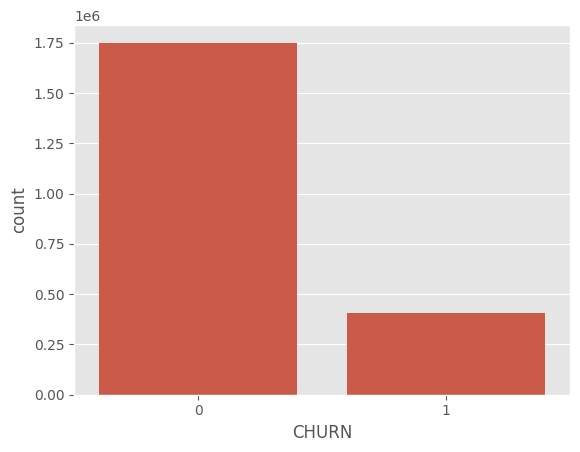

In [12]:
sns.countplot(data=df, x="CHURN")
plt.show()

## Data preprocessing

In [13]:
X = df.drop(["user_id", "MRG", "ZONE1", "ZONE2", "CHURN"], axis=1)
y = df.CHURN

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(f'Train size: {X_train.shape}')
print(f'Test size: {X_test.shape}')

Train size: (2046345, 14)
Test size: (107703, 14)


In [15]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        # Impute missing values in categorical columns and then apply one-hot encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols),
        # Impute missing values in numerical columns and then apply scaling
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols)
    ], remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [53]:
oversampling = SMOTE(random_state=42, k_neighbors=3, n_jobs=-1)
X_resampled, y_resampled = oversampling.fit_resample(X_train_processed, y_train)

print(f'Size after resampling: {X_resampled.shape}')
print(f'Size before resampling: {X_train_processed.shape}')

Size after resampling: (3324966, 175)
Size before resampling: (2046345, 175)


## Model Training

### Traditional

In [54]:
xgb = XGBClassifier(n_jobs=-1)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [55]:
#xgb.fit(X_resampled, y_resampled)
xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb.predict(X_test_processed)

In [18]:
#rf.fit(X_resampled, y_resampled)
rf.fit(X_train_processed, y_train)
y_pred_rf = rf.predict(X_test_processed)

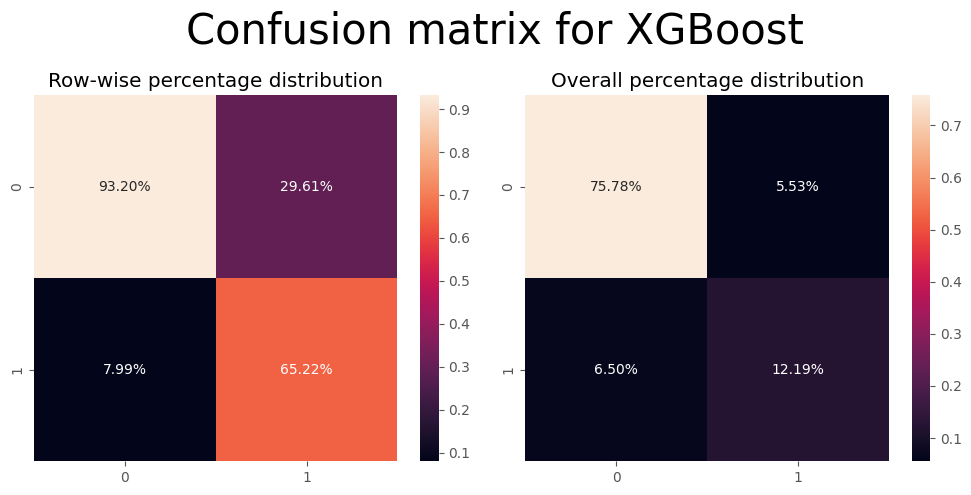

Accuracy: 0.8796783747899316


In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb_perc = cm_xgb / cm_xgb.sum(axis=1)

sns.heatmap(cm_xgb_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for XGBoost", fontsize=30)
plt.tight_layout()
plt.show()

print(f'Accuracy: {xgb.score(X_test_processed, y_test)}')

In [20]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     87579
           1       0.69      0.66      0.67     20124

    accuracy                           0.88    107703
   macro avg       0.80      0.79      0.80    107703
weighted avg       0.88      0.88      0.88    107703



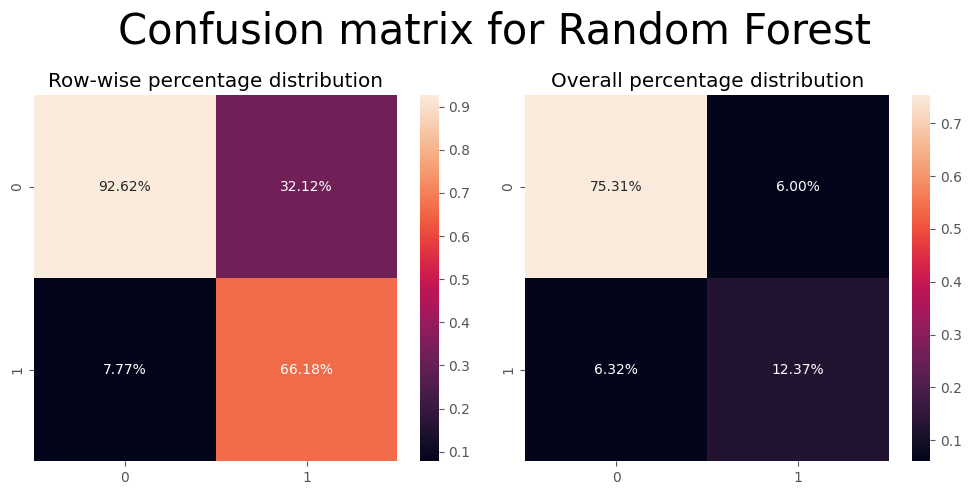

Accuracy: 0.8768000891340074


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_perc = cm_rf / cm_rf.sum(axis=1)

sns.heatmap(cm_rf_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_rf, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for Random Forest", fontsize=30)
plt.tight_layout()
plt.show()

print(f'Accuracy: {rf.score(X_test_processed, y_test)}')

In [22]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     87579
           1       0.67      0.66      0.67     20124

    accuracy                           0.88    107703
   macro avg       0.80      0.79      0.80    107703
weighted avg       0.88      0.88      0.88    107703



In [57]:
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_rf = accuracy_score(y_test, y_pred_rf)

### Deep learning

In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [58]:
dnn = Sequential()

# Input layer
dnn.add(Dense(1024, input_dim=X_resampled.shape[1], activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
#dnn.add(Dense(1024, input_dim=X_train_processed.shape[1], activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(BatchNormalization())

# Hidden layers
dnn.add(Dense(512, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(Dropout(0.3))  
dnn.add(BatchNormalization())

dnn.add(Dense(256, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(Dropout(0.3))  
dnn.add(BatchNormalization())

# Output layer
dnn.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

dnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1024)              180224    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 256)              

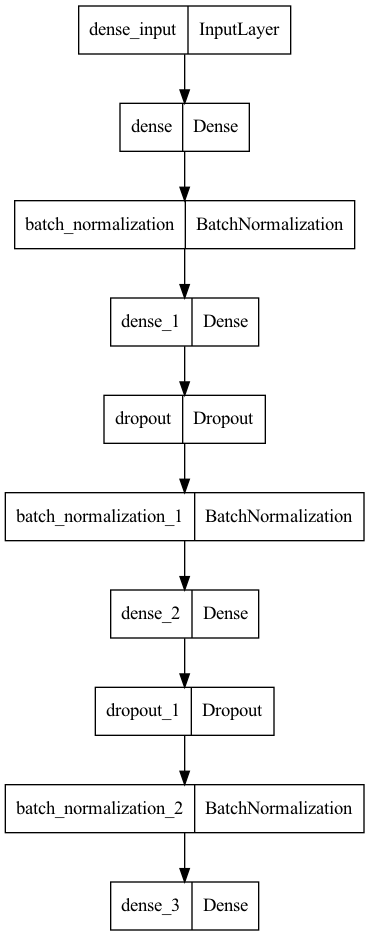

In [26]:
plot_model(dnn, to_file="../dnn.png")

In [59]:
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
with tf.device('/cpu:0'):
    #history_dnn = dnn.fit(X_train_processed, y_train, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])
    history_dnn = dnn.fit(X_resampled, y_resampled, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
24678/24678 [==============================] - 217s 9ms/step - loss: 0.3508 - accuracy: 0.8567 - val_loss: 0.3286 - val_accuracy: 0.9006
Epoch 2/10
24678/24678 [==============================] - 199s 8ms/step - loss: 0.3356 - accuracy: 0.8580 - val_loss: 0.3059 - val_accuracy: 0.9167
Epoch 3/10
24678/24678 [==============================] - 207s 8ms/step - loss: 0.3338 - accuracy: 0.8582 - val_loss: 0.3061 - val_accuracy: 0.9237
Epoch 4/10
24678/24678 [==============================] - 197s 8ms/step - loss: 0.3334 - accuracy: 0.8584 - val_loss: 0.3053 - val_accuracy: 0.9046
Epoch 5/10
24678/24678 [==============================] - 196s 8ms/step - loss: 0.3331 - accuracy: 0.8586 - val_loss: 0.3048 - val_accuracy: 0.9198
Epoch 6/10
24678/24678 [==============================] - 189s 8ms/step - loss: 0.3331 - accuracy: 0.8585 - val_loss: 0.2782 - val_accuracy: 0.9293
Epoch 7/10
24678/24678 [==============================] - 189s 8ms/step - loss: 0.3332 - accuracy: 0.8585 - val_

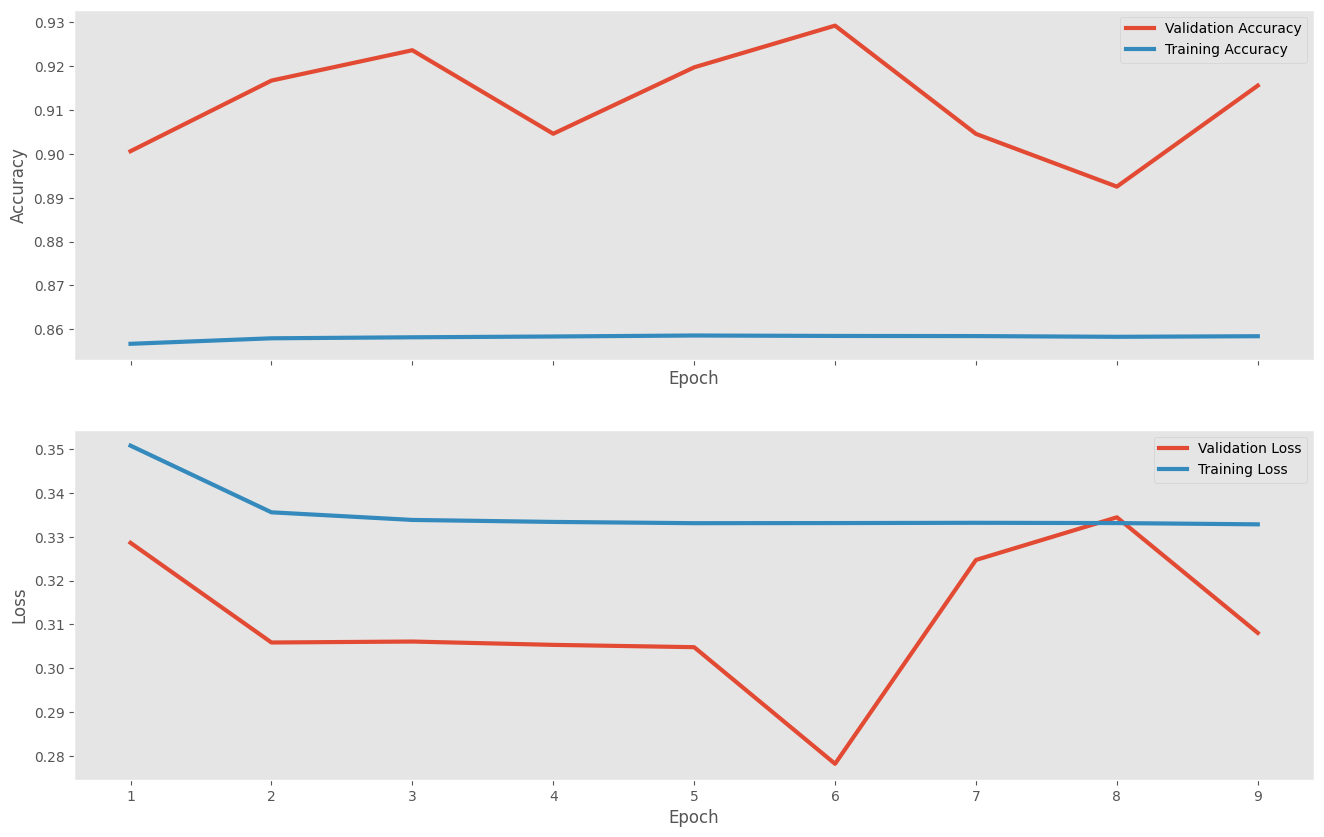

In [62]:
plot_results(history_dnn)

In [63]:
dnn.save("../models/dnn.h5")

In [64]:
load_dnn = load_model("../models/dnn.h5")

3366/3366 [==============================] - 2s 705us/step
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     87579
           1       0.52      0.93      0.67     20124

    accuracy                           0.82    107703
   macro avg       0.75      0.87      0.77    107703
weighted avg       0.89      0.82      0.84    107703



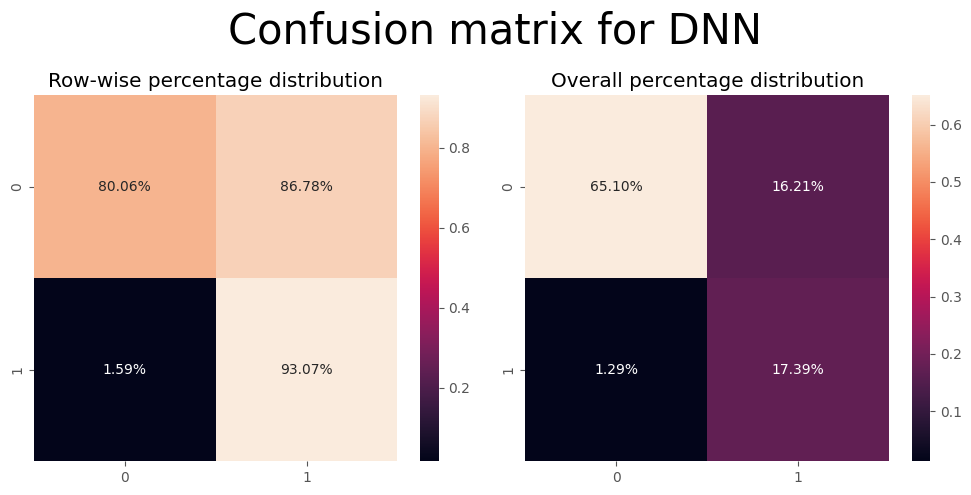

3366/3366 [==============================] - 3s 787us/step - loss: 0.3525 - accuracy: 0.8249
DNN: Loss is 0.3524553179740906, Accuracy is 0.824916660785675


In [65]:
y_pred_dnn = load_dnn.predict(X_test_processed)
y_pred_dnn_bin = (y_pred_dnn > 0.5).astype('int32')

print(classification_report(y_test, y_pred_dnn_bin))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_dnn = confusion_matrix(y_test, y_pred_dnn_bin)
cm_dnn_perc = cm_dnn / cm_dnn.sum(axis=1)

sns.heatmap(cm_dnn_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_dnn_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for DNN", fontsize=30)
plt.tight_layout()
plt.show()

loss, accuracy = dnn.evaluate(X_test_processed, y_test)
print(f"DNN: Loss is {loss}, Accuracy is {accuracy}")

In [33]:
rnn = Sequential()

rnn.add(Bidirectional(LSTM(units=8, return_sequences=True), input_shape=(X_train_processed.shape[1], 1)))
#rnn.add(Activation(swish))
rnn.add(Dropout(0.2))

rnn.add(Bidirectional(LSTM(units=8, return_sequences=True)))
#rnn.add(Activation(swish))
rnn.add(Dropout(0.2))
rnn.add(BatchNormalization())

# Output layer for binary classification
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 175, 16)           640       
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 175, 16)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 175, 16)           1600      
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 175, 16)           0         
                                                                 
 batch_normalization_3 (Bat  (None, 175, 16)           64        
 chNormalization)                                                
                                                      

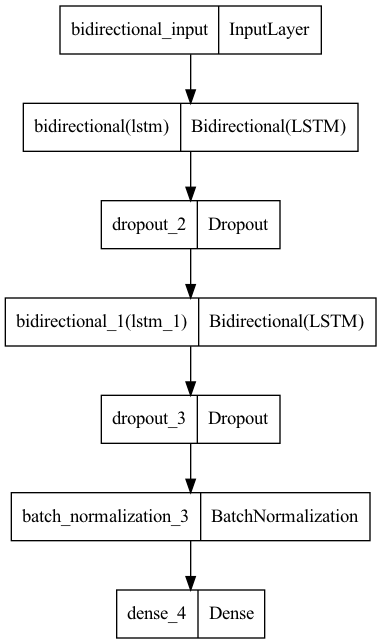

In [41]:
plot_model(rnn, to_file="../rnn.png")

In [35]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
with tf.device('/cpu:0'):
    history_rnn = rnn.fit(X_train_processed, y_train, epochs=10, batch_size=64, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
30376/30376 [==============================] - 1217s 40ms/step - loss: 0.3087 - accuracy: 0.8541 - val_loss: 0.2705 - val_accuracy: 0.8736
Epoch 2/10
30376/30376 [==============================] - 1365s 45ms/step - loss: 0.2727 - accuracy: 0.8722 - val_loss: 0.2852 - val_accuracy: 0.8679
Epoch 3/10
30376/30376 [==============================] - 1091s 36ms/step - loss: 0.2954 - accuracy: 0.8639 - val_loss: 0.2637 - val_accuracy: 0.8765
Epoch 4/10
30376/30376 [==============================] - 930s 31ms/step - loss: 0.2659 - accuracy: 0.8748 - val_loss: 0.2617 - val_accuracy: 0.8740
Epoch 5/10
30376/30376 [==============================] - 908s 30ms/step - loss: 0.2632 - accuracy: 0.8755 - val_loss: 0.2607 - val_accuracy: 0.8758
Epoch 6/10
30376/30376 [==============================] - 909s 30ms/step - loss: 0.2630 - accuracy: 0.8756 - val_loss: 0.2633 - val_accuracy: 0.8755


In [37]:
rnn.save("../models/rnn.h5")

In [38]:
load_rnn = load_model("../models/rnn.h5")

3366/3366 [==============================] - 20s 6ms/step


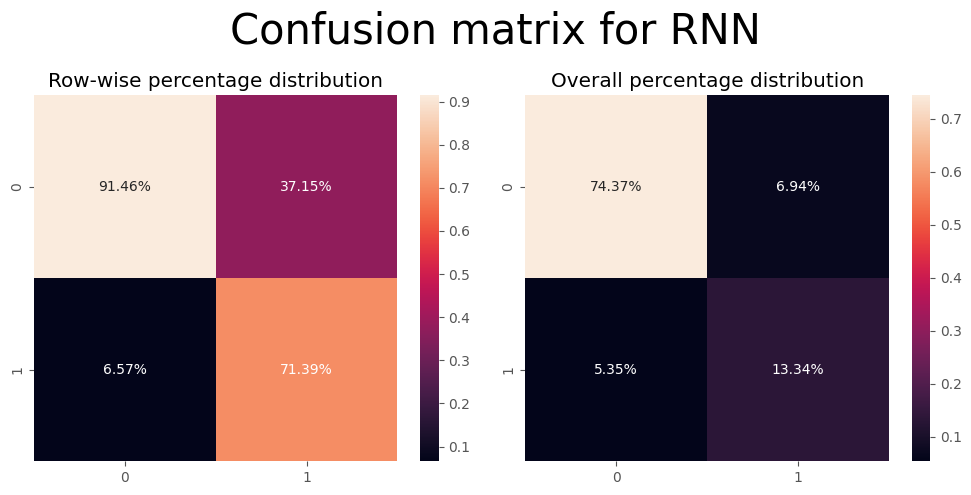

3366/3366 [==============================] - 21s 6ms/step - loss: 0.2591 - accuracy: 0.8778
RNN: Loss is 0.2591177821159363, Accuracy is 0.8777559995651245


In [39]:
y_pred_rnn = load_rnn.predict(X_test_processed)
y_pred_rnn_bin = []

for i in y_pred_rnn:
  if (i > 0.5).any():
     y_pred_rnn_bin.append(1)
  else:
     y_pred_rnn_bin.append(0)

cm_rnn = confusion_matrix(y_test, y_pred_rnn_bin)
cm_rnn_perc = cm_rnn / cm_rnn.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(cm_rnn_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_rnn_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for RNN", fontsize=30)
plt.tight_layout()
plt.show()

loss_2, accuracy_2 = load_rnn.evaluate(X_test_processed, y_test)
print(f"RNN: Loss is {loss_2}, Accuracy is {accuracy_2}")

In [42]:
# DNN
input_dnn = Input(shape=(X_train_processed.shape[1],))
x_dnn = Dense(1024, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(input_dnn)

x_dnn = Dense(512, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)

x_dnn = Dense(256, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)

x_dnn = Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)
x_dnn = BatchNormalization()(x_dnn)

# RNN
input_rnn = Input(shape=(X_train_processed.shape[1], 1))
x_rnn = Bidirectional(LSTM(units=8, return_sequences=True))(input_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)

x_rnn = Bidirectional(LSTM(units=8, return_sequences=True))(input_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)

x_rnn = Bidirectional(LSTM(units=8, return_sequences=False))(x_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)
x_rnn = BatchNormalization()(x_rnn)

# Concat
combined = concatenate([x_dnn, x_rnn])

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(combined)

In [43]:
ensemble_model = Model(inputs=[input_dnn, input_rnn], outputs=output)
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 175)]                0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 1024)                 180224    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 175, 1)]             0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 512)                  524800    ['dense_5[0][0]']             
                                                                                              

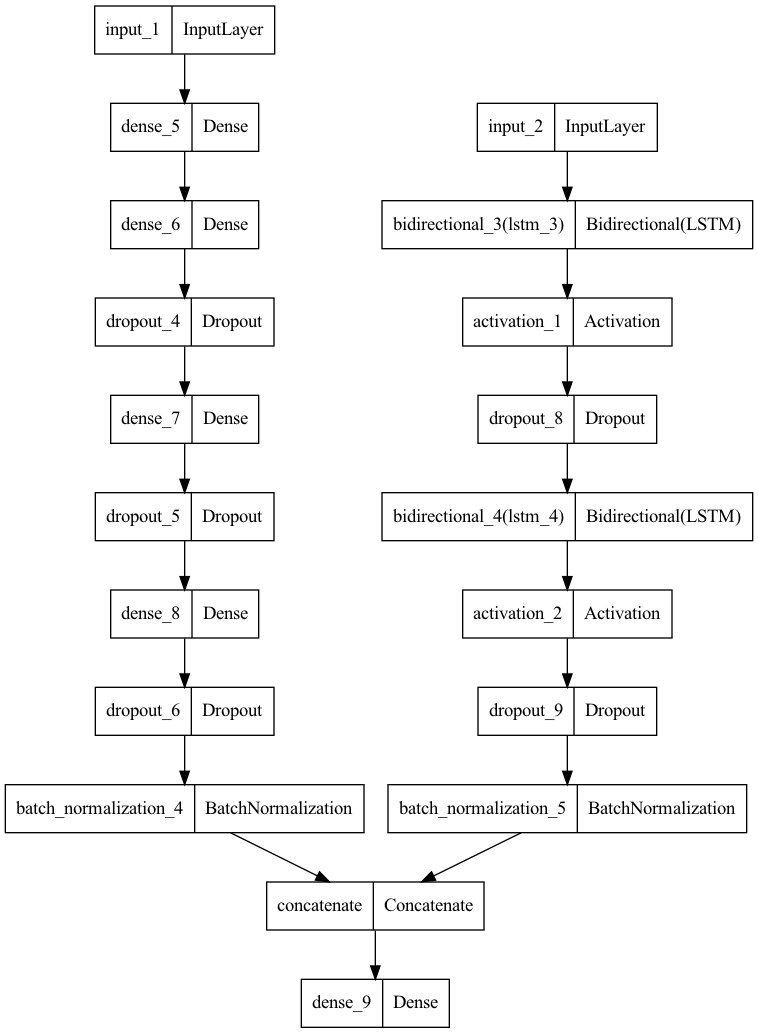

In [44]:
plot_model(ensemble_model, to_file="../ensemble.png")

In [45]:
optimizer = Adam(learning_rate=0.001)

ensemble_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
with tf.device('/gpu:0'):
    history_ens = ensemble_model.fit([X_train_processed, X_train_processed], y_train, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
15188/15188 [==============================] - 710s 47ms/step - loss: 0.3078 - accuracy: 0.8735 - val_loss: 0.2690 - val_accuracy: 0.8751
Epoch 2/10
15188/15188 [==============================] - 859s 57ms/step - loss: 0.2707 - accuracy: 0.8749 - val_loss: 0.2628 - val_accuracy: 0.8763
Epoch 3/10
15188/15188 [==============================] - 960s 63ms/step - loss: 0.2682 - accuracy: 0.8752 - val_loss: 0.2633 - val_accuracy: 0.8762
Epoch 4/10
15188/15188 [==============================] - 788s 52ms/step - loss: 0.2699 - accuracy: 0.8745 - val_loss: 0.2630 - val_accuracy: 0.8773
Epoch 5/10
15188/15188 [==============================] - 1234s 81ms/step - loss: 0.2691 - accuracy: 0.8748 - val_loss: 0.2627 - val_accuracy: 0.8768
Epoch 6/10
15188/15188 [==============================] - 752s 50ms/step - loss: 0.2687 - accuracy: 0.8750 - val_loss: 0.2620 - val_accuracy: 0.8776
Epoch 7/10
15188/15188 [==============================] - 614s 40ms/step - loss: 0.2682 - accuracy: 0.875

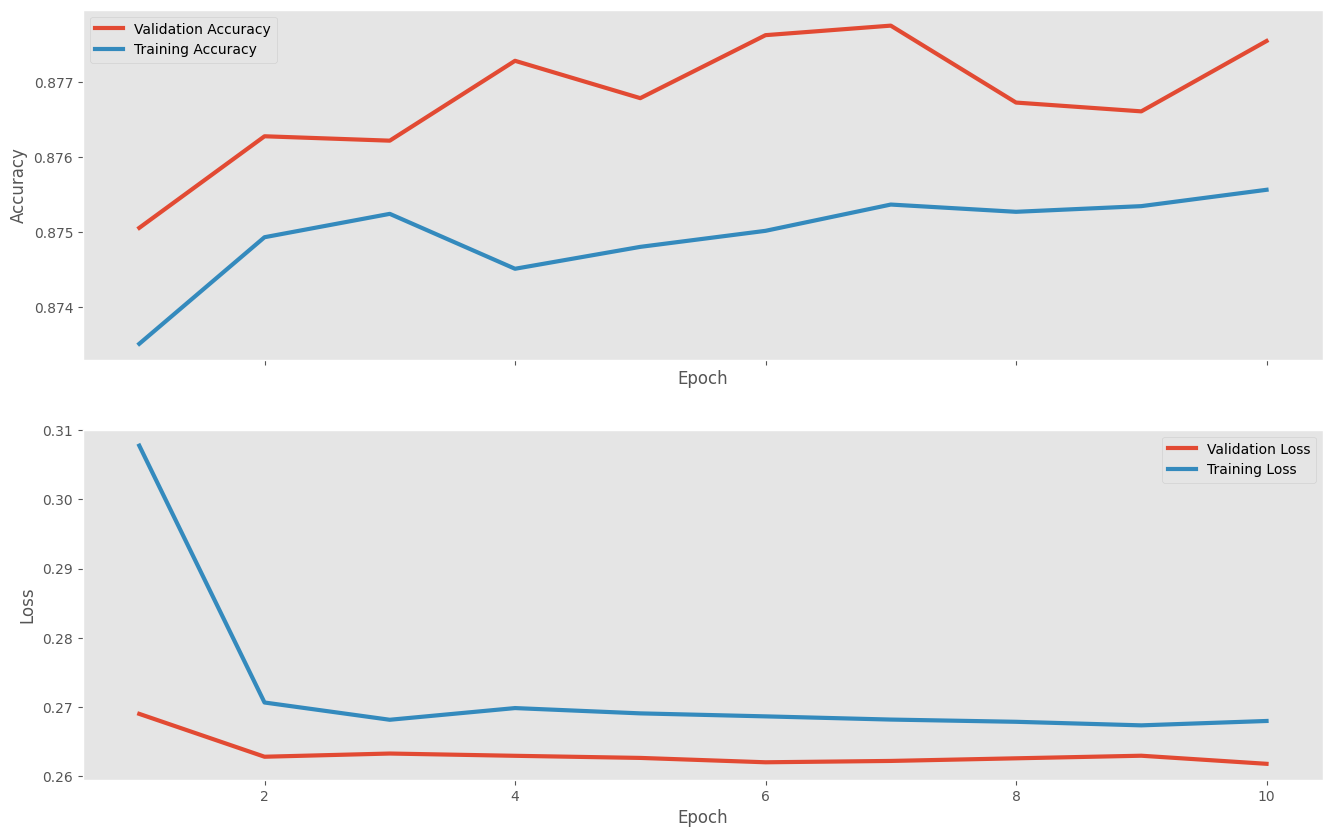

In [47]:
plot_results(history_ens)

In [48]:
ensemble_model.save("../models/ensemble.h5")

In [49]:
load_ens = load_model("../models/ensemble.h5")

3366/3366 [==============================] - 21s 6ms/step


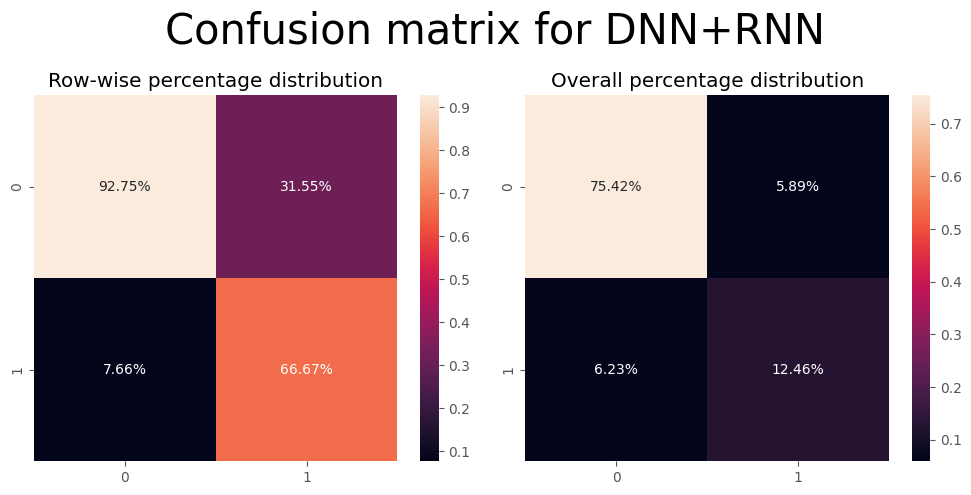

3366/3366 [==============================] - 22s 6ms/step - loss: 0.2581 - accuracy: 0.8788
Ensemble: Loss is 0.25807979702949524, Accuracy is 0.8787777423858643


In [50]:
y_pred_ens = load_ens.predict([X_test_processed, X_test_processed])
y_pred_ens_bin = (y_pred_ens > 0.5).astype('int32')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_ens = confusion_matrix(y_test, y_pred_ens_bin)
cm_ens_perc = cm_ens / cm_ens.sum(axis=1)

sns.heatmap(cm_ens_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_ens_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for DNN+RNN", fontsize=30)
plt.tight_layout()
plt.show()

loss_3, accuracy_3 = load_ens.evaluate([X_test_processed, X_test_processed], y_test)
print(f"Ensemble: Loss is {loss_3}, Accuracy is {accuracy_3}")

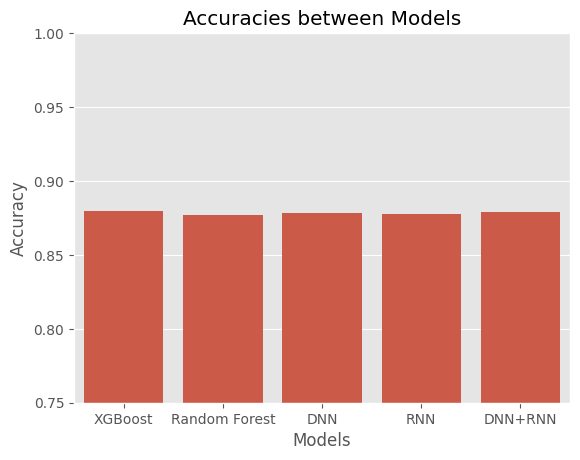

In [51]:
# Make a graph on all accuracies
accs_dict = {
    "XGBoost": [acc_xgb],
    "Random Forest": [acc_rf],
    "DNN": [accuracy],
    "RNN": [accuracy_2],
    "DNN+RNN": [accuracy_3]
}

accs_df = pd.DataFrame.from_dict(accs_dict, orient='index', columns=["Accuracies"])

sns.barplot(data=accs_df, x=accs_df.index, y='Accuracies')
plt.ylim(0.75, 1)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracies between Models")
plt.show()